In [1]:
import sys
import os

import matplotlib.pyplot as plt

from Mala.mala import MALAKernel

# Add the parent directory to sys.path so Python can find the files
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [2]:
from EKI.eki import *
from EKI.stopping_rules import *
from EKI.uq import *
from ForwardModels.models import *
from Utils.tools import *

In [3]:

data = [
    {
        "type": "Smooth",
        "results": []
    },
    {
        "type": "Rough",
        "results": []
    }
]

In [4]:
def run(f0, dim_parameters, dim_observations, p, num_particles, noise_level=1e-6):
    """Run a simple EKI example."""
    # Set random seed for reproducibility
    key = random.PRNGKey(42)

    forward_model = LinearForwardModel(
        dim_parameters, dim_observations, p, coef=1
    )
    #i_array =jnp.linspace(1, dim_parameters, dim_parameters)



    y_true = forward_model.evaluate(f0) #(dim_parms, )

    # Add noise to observations
    key, subkey = random.split(key)
    noise = noise_level * random.normal(subkey, y_true.shape)
    observations = y_true + noise
    # plt.plot(i_array, f0)
    # plt.plot(i_array, y_true)
    # plt.show()

    plt.show()
    prior_cov = GaussianKernel(dim_parameters, 1)._operator_fourier
    # Initialize EKI solver
    eki = EKI(
        forward_model=forward_model,
        observations=observations,
        dim_parameters=dim_parameters,
        num_particles=num_particles,
        init_covariance=prior_cov,
        init_mean=jnp.zeros(dim_parameters),
        noise_level=noise_level,
        time_interval=(1, 150.0, 200),  # (start, end, max_steps)
        rng_key=key,
    )

    # Create stopping rule: Discrepancy principle
    stopping_rule = DiscrepancyPrinciple(
        effective_dim=dim_observations,
        tolerance=noise_level,
        kappa=1,
        max_iterations=100,
    )

    # Run the algorithm with early stopping
    results = eki.fit(stopping_rule=stopping_rule)

    # Print results
    print(f"\nAlgorithm converged: {results['converged']}")
    print(f"Stopping time: {results['stopping_time']}")
    print(f"Final residual: {results['final_residual']:.6f}")

    return results

In [5]:
# global parameters
dim_parameters = 100
dim_observations = 100
p = 1/2
beta = 1
num_particles = 100

noise_levels = [1e-2,1e-4,1e-6,1e-8]
print(noise_levels)

[0.01, 0.0001, 1e-06, 1e-08]


In [6]:
i_array =jnp.linspace(1, dim_parameters, dim_parameters)

frough = jnp.apply_along_axis(lambda x: (5*jnp.sin(0.5*x))*x ** (-beta), 0, i_array)
fsmooth = jnp.apply_along_axis(lambda x: (5*jnp.exp(-x)), 0, i_array)

In [7]:
data[0]['f0'] = fsmooth
data[1]['f0'] = frough

In [8]:
for i in range(len(data)):
    f0 = data[i]['f0']
    results_list = []
    for noise_level in noise_levels:
        results = run(f0, dim_parameters, dim_observations, p, num_particles, noise_level)
        results_list.append(results)
    data[i]["results"] = results_list

0
1
2
converged

Algorithm converged: True
Stopping time: 2
Final residual: 0.114013
0
1
2
converged

Algorithm converged: True
Stopping time: 2
Final residual: 0.008022
0
1
2
converged

Algorithm converged: True
Stopping time: 2
Final residual: 0.002309
0
1
2
converged

Algorithm converged: True
Stopping time: 2
Final residual: 0.000997
0
1
2
converged

Algorithm converged: True
Stopping time: 2
Final residual: 0.571164
0
1
2
3
converged

Algorithm converged: True
Stopping time: 3
Final residual: 0.092313
0
1
2
3
4
5
6
7
8
9
10
11
12
13
converged

Algorithm converged: True
Stopping time: 13
Final residual: 0.009816
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
12

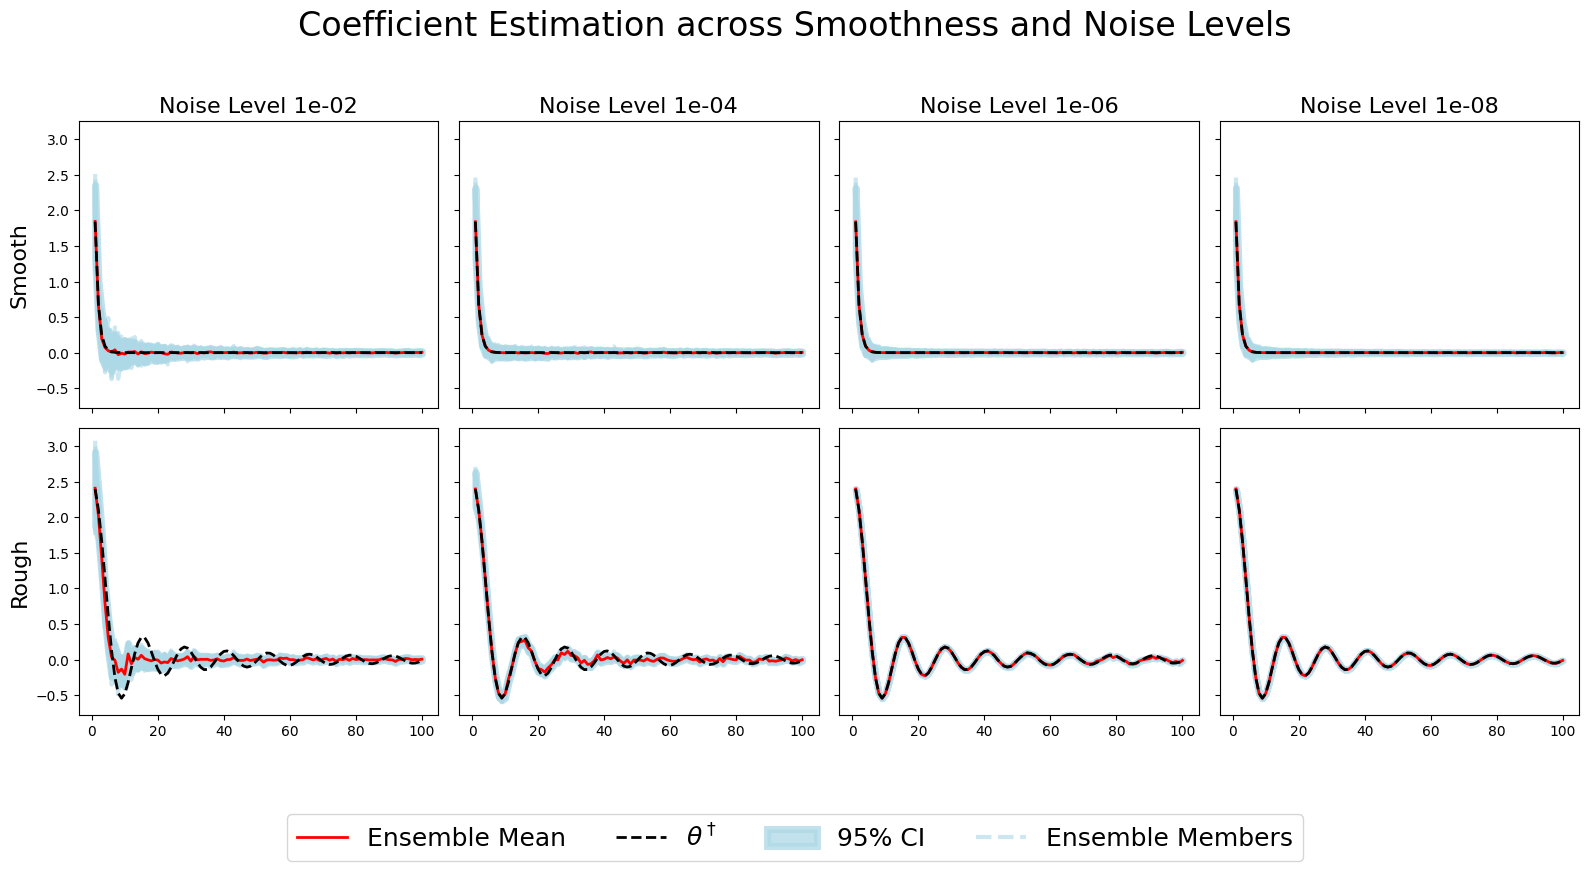

In [9]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

i_array = jnp.linspace(1, 100, 100)
q = jnp.array([0.025, 0.975])

num_experiments = len(data)
num_levels = len(data[0]["results"])  # assuming same number of noise levels for each

fig, axes = plt.subplots(num_experiments, num_levels, figsize=(4*num_levels, 4*num_experiments), sharex=True, sharey=True)

# Handle the case where there's only one experiment or one noise level
if num_experiments == 1:
    axes = [axes]
if num_levels == 1:
    axes = [[ax] for ax in axes]

# Loop over experiments (rows)
for row_idx, item in enumerate(data):
    f0 = item["f0"]
    type_label = item["type"]

    for col_idx, results in enumerate(item["results"]):
        ax = axes[row_idx][col_idx]
        hat_coefs_f0_ensemble = results["ensemble_history"][-1]

        # Plot individual ensemble members
        ensemble_members_handle = ax.plot(
            i_array, hat_coefs_f0_ensemble,
            color="lightblue", linestyle="dashed", alpha=0.6, linewidth=3
        )

        # Ensemble mean
        ensemble_mean_handle, = ax.plot(
            i_array, jnp.mean(hat_coefs_f0_ensemble, axis=1),
            color="red", linewidth=2, label="ensemble mean"
        )

        # True v0
        f0_handle, = ax.plot(i_array, f0, color="black", label=r"$\theta^\dagger$",
                             linestyle="dashed", linewidth=2)

        # Quantiles
        quantiles = jnp.quantile(hat_coefs_f0_ensemble, q, axis=1)
        fill_handle = ax.fill_between(
            i_array, quantiles[0], quantiles[1],
            color="lightblue", alpha=0.75, label="95% CI", linewidth=5
        )

        # Axis labels
        if col_idx == 0:
            ax.set_ylabel(f"{type_label}", fontsize=16)
        if row_idx == 0:
            ax.set_title(f"Noise Level {noise_levels[col_idx]:.0e}", fontsize=16)

# Common legend
handles = [ensemble_mean_handle, f0_handle, fill_handle, ensemble_members_handle[0]]
labels = ["Ensemble Mean", r"$\theta^\dagger$", "95% CI", "Ensemble Members"]
fig.legend(handles, labels, loc='lower center', ncol=4, fontsize=18, bbox_to_anchor=(0.5, -0.1))

# Main title
fig.suptitle(r"Coefficient Estimation across Smoothness and Noise Levels", fontsize=24)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()
